In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm
import zipfile

In [24]:
transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

In [ ]:
!unzip nature_12K.zip

In [39]:

classes = ('Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia')

In [25]:
train_data_path = '/home/bincy/A2/CS-6910-A2/inaturalist_12K/train'
test_data_path = '/home/bincy/A2/CS-6910-A2/inaturalist_12K/val'

# Create datasets from the directories
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

In [26]:
batch_size=4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [50]:
# Check images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("the images batch",images.shape)

print("a single item",images[3].shape)
print("label of item",labels[3].item())

the images batch torch.Size([4, 3, 224, 224])
a single item torch.Size([3, 224, 224])
label of item 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
(3, 224, 224)
(224, 224, 3)


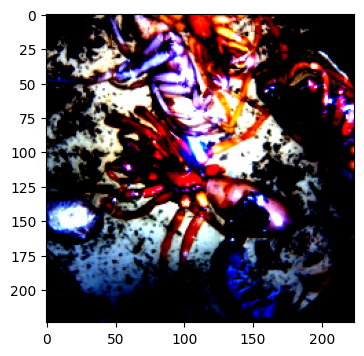

In [51]:
#visualising
img = images[2]
print(type(img))
npimg = img.numpy()
print(npimg.shape)
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)
plt.figure(figsize = (4,4))
plt.imshow(npimg)
plt.show()

In [52]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


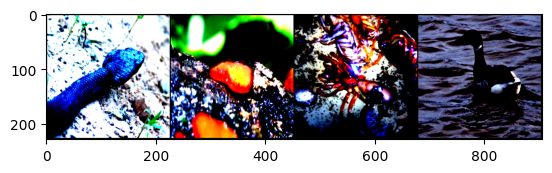

Reptilia Fungi Arachnida Aves


In [53]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

In [54]:
class FirstCNN_v3(nn.Module):
    def __init__(self): 
        super(FirstCNN_v3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [57]:


class CNN(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=[32, 64, 128, 256, 512], kernel_size=3, pool_size=2, dense_neurons=100):
        super(CNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        for out_channels in num_filters:
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(pool_size)
                )
            )
            in_channels = out_channels
        
        # Define dense layers
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters[-1] * (224 // (pool_size**len(num_filters))) * (224 // (pool_size**len(num_filters))), dense_neurons),
            nn.ReLU(),
            nn.Linear(dense_neurons, num_classes)
        )
        
    def forward(self, x):
        # Pass input through convolutional layers
        for layer in self.conv_layers:
            x = layer(x)
        
        # Pass output through dense layers
        x = self.dense_layers(x)
        return x

# Instantiate the model
model = CNN(num_classes=10)
print(model)
out=model(images)
print(out)


CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Max